### Risk Category Prediction

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('data/events_with_churn_score.csv')

In [4]:
class RiskCategoryClassifier:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.model = None
        self.feature_names = None
        
    def prepare_data(self, df):
        # Drop columns that shouldn't be used for prediction
        cols_to_drop = ['user_id', 'risk_category', 'is_likely_churn', 'primary_risk_drivers', 
                       'estimated_days_to_churn', 'churn_score', 'risk_velocity']
        
        # Store feature names for later use
        self.feature_names = [col for col in df.columns if col not in cols_to_drop]
        
        # Prepare X and y
        X = df[self.feature_names]
        y = df['risk_category']
        
        # Encode target variable
        y_encoded = self.label_encoder.fit_transform(y)
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        return X_scaled, y_encoded
    
    def train_model(self, X, y):
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Define Random Forest parameters for grid search
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2, 4]
        }
        
        # Initialize and train Random Forest with GridSearchCV
        rf = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(
            rf,
            param_grid,
            cv=5,
            scoring='f1_weighted',
            n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        self.model = grid_search.best_estimator_
        
        # Print best parameters
        print("\nBest Parameters:")
        print(grid_search.best_params_)
        
        # Calculate predictions
        y_pred = self.model.predict(X_test)
        y_pred_proba = self.model.predict_proba(X_test)
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, 
                                 target_names=self.label_encoder.classes_))
        
        # Calculate and plot ROC curves
        self.plot_roc_curves(X_test, y_test)
        
        # Plot confusion matrix
        self.plot_confusion_matrix(y_test, y_pred)
        
        return X_train, X_test, y_train, y_test
    
    def plot_roc_curves(self, X_test, y_test):
        # Binarize the output for ROC curve
        y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
        y_score = self.model.predict_proba(X_test)
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        n_classes = len(np.unique(y_test))
        
        plt.figure(figsize=(10, 8))
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
            plt.plot(fpr[i], tpr[i],
                    label=f'ROC curve of {self.label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curves')
        plt.legend(loc="lower right")
        plt.show()
        
        # Print AUC scores
        print("\nAUC-ROC Scores:")
        for i in range(n_classes):
            print(f"{self.label_encoder.classes_[i]}: {roc_auc[i]:.3f}")
    
    def plot_confusion_matrix(self, y_test, y_pred):
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d',
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    
    def analyze_feature_importance(self, X):
        # Get feature importance from Random Forest
        importance = self.model.feature_importances_
        
        # Create DataFrame with feature names and importance
        feature_importance = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
        plt.title('Top 15 Most Important Features (Random Forest)')
        plt.tight_layout()
        plt.show()
        
        return feature_importance


Best Parameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Classification Report:
              precision    recall  f1-score   support

        High       0.91      0.87      0.89       386
         Low       0.93      0.94      0.94       928
      Medium       0.92      0.95      0.94      1144
    Very Low       0.91      0.84      0.87       213

    accuracy                           0.92      2671
   macro avg       0.92      0.90      0.91      2671
weighted avg       0.92      0.92      0.92      2671



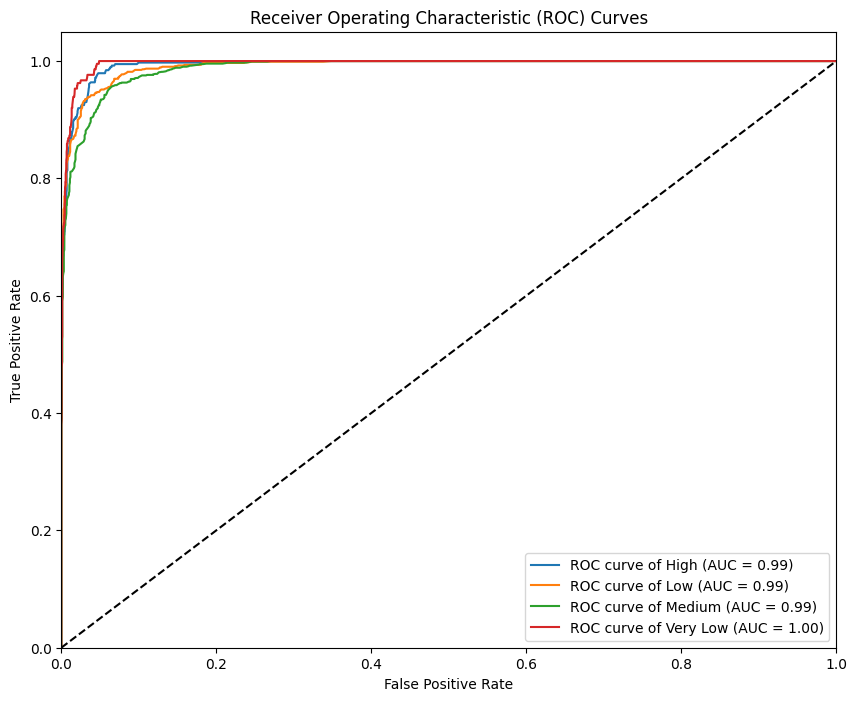


AUC-ROC Scores:
High: 0.994
Low: 0.992
Medium: 0.988
Very Low: 0.996


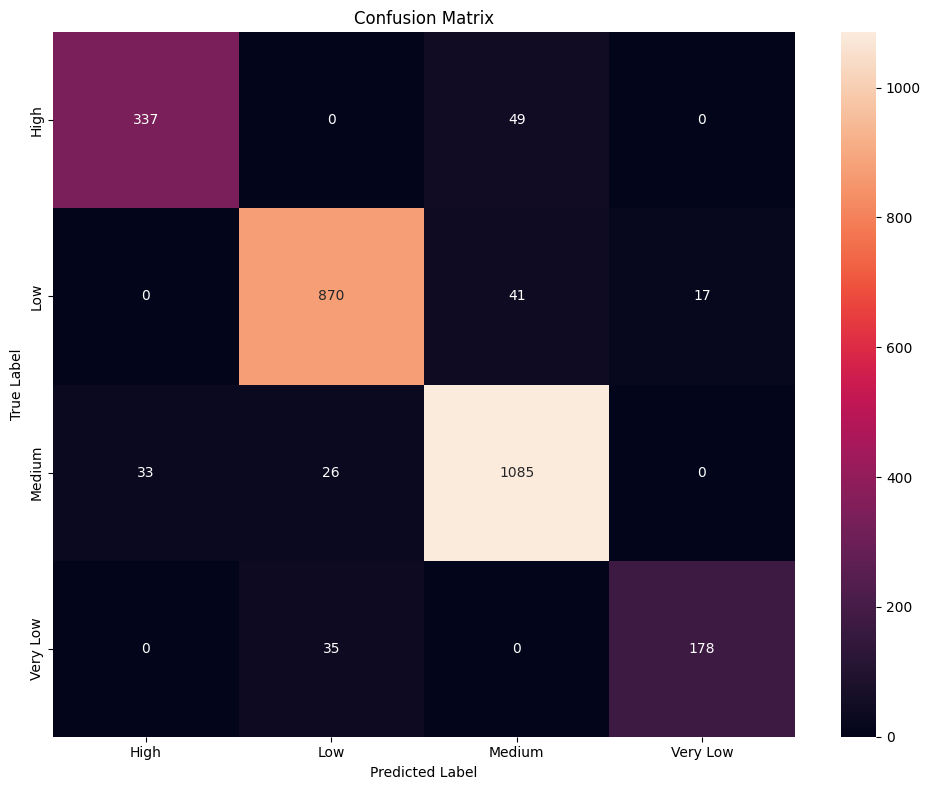

In [5]:
classifier = RiskCategoryClassifier()
X_scaled, y_encoded = classifier.prepare_data(df)
X_train, X_test, y_train, y_test = classifier.train_model(X_scaled, y_encoded)

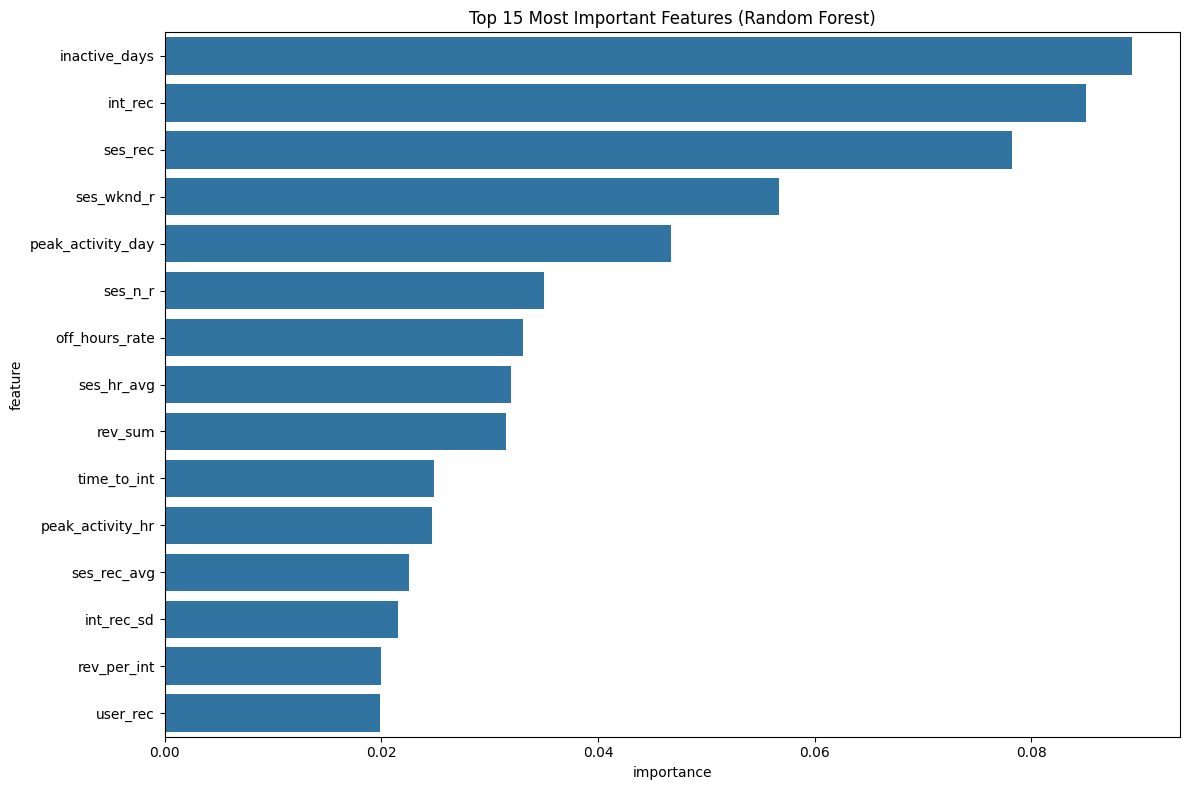


Importance of Features:
inactive_days: 0.0893
int_rec: 0.0851
ses_rec: 0.0782
ses_wknd_r: 0.0567
peak_activity_day: 0.0467
ses_n_r: 0.0350
off_hours_rate: 0.0331
ses_hr_avg: 0.0320
rev_sum: 0.0315
time_to_int: 0.0249
peak_activity_hr: 0.0247
ses_rec_avg: 0.0226
int_rec_sd: 0.0216
rev_per_int: 0.0200
user_rec: 0.0199
ses_len_avg: 0.0189
rev_sum_r: 0.0188
int_cat_n_avg: 0.0177
cross_cat_ratio: 0.0172
int_n: 0.0170
ses_mo_sd: 0.0161
int_n_r: 0.0161
rev_per_purchase: 0.0156
ses_gap_sd: 0.0154
tran_n_r: 0.0151
purchase_count: 0.0150
view_count: 0.0150
tran_n: 0.0140
ses_hr_sd: 0.0131
ses_len_sd: 0.0123
ses_rec_sd: 0.0115
ses_mo_avg: 0.0100
int_cat_n: 0.0100
pop_cat_consistency: 0.0092
ses_n: 0.0088
int_skew: 0.0088
view_to_cart_avg: 0.0082
int_itm_n_avg: 0.0081
int_itm_n: 0.0077
cart_to_purchase_avg: 0.0075
short_ses_ratio: 0.0074
ses_len_cv: 0.0074
purchase_consistency: 0.0071
ses_rec_cv: 0.0071
long_ses_ratio: 0.0067
time_to_tran: 0.0067
cart_count: 0.0060
major_spend_r: 0.0030
high_spik

In [7]:
feature_importance = classifier.analyze_feature_importance(X_train)

print("\nImportance of Features:")
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")